In [2]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn import metrics

In [3]:
img_path='C:/School/ECE539/Project/R-CNN/Data/Images'
annot_path='C:/School/ECE539/Project/R-CNN/Data/Annotations'

# img_path='./Data/Images'
# annot_path='./Data/Annotations'

apple_1.jpg


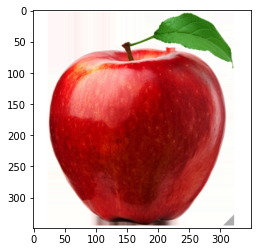

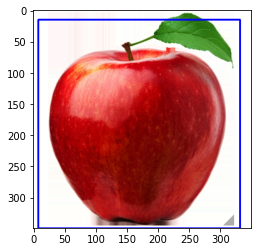

In [4]:
for e,i in enumerate(os.listdir(annot_path)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(img_path,filename))
        df = pd.read_csv(os.path.join(annot_path,i))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        break

In [5]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [6]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [7]:
train_images=[]
train_labels=[]
apple_count = 0
orange_count = 0
banana_count = 0
for e,i in enumerate(os.listdir(annot_path)):
    try:
        filename = i.split(".")[0]+".jpg"
        label_str = filename.split('_')[0]
        label_num = 0
        if label_str == 'apple':
            label_num = 1
        elif label_str == 'banana':
            label_num = 2   
        elif label_str == 'orange':
             label_num = 3
        elif label_str == 'mixed':
          continue
        image = cv2.imread(os.path.join(img_path,filename))
        df = pd.read_csv(os.path.join(annot_path,i))
        gtvalues=[]
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = image.copy()
        # plt.imshow(imout)
        # break
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        for e,result in enumerate(ssresults):
            if e < 2000 and flag == 0:
                for gtval in gtvalues:
                    x,y,w,h = result
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if counter < 30:
                        if iou > 0.75:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(label_num)
                            counter += 1
                    else :
                        fflag =1
                    if falsecounter <30:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    #print("inside")
                    flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

In [8]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

print(X_new.shape)
print(y_new.shape)

(12224, 224, 224, 3)
(12224,)


In [9]:
# TODO use resnet50 instead of vgg16
resmodel = tf.keras.applications.resnet50.ResNet50(include_top=True,weights='imagenet',)
resmodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [10]:
for layers in (resmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [11]:
X= resmodel.layers[-2].output

In [12]:
# predictions = Dense(2, activation="softmax")(X)
predictions = Dense(4, activation="softmax")(X)

In [13]:
model_final = Model(resmodel.input, predictions)

In [14]:
opt = Adam(learning_rate=0.0001)

In [15]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [16]:
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [17]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [18]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [19]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(11001, 224, 224, 3) (1223, 224, 224, 3) (11001, 4) (1223, 4)


In [20]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [21]:
checkpoint = ModelCheckpoint("ieeercnn_resnet_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [22]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 50, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])


C:\Users\Xurso\AppData\Local\Temp\ipykernel_22104\3247725977.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 50, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])


Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 0.8784 - accuracy: 0.7188
Epoch 1: val_loss improved from inf to 0.50632, saving model to ieeercnn_resnet_1.h5
10/10 [==============================] - 79s 7s/step - loss: 0.8784 - accuracy: 0.7188 - val_loss: 0.5063 - val_accuracy: 0.8281
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.2123 - accuracy: 0.9406
Epoch 2: val_loss improved from 0.50632 to 0.35861, saving model to ieeercnn_resnet_1.h5
10/10 [==============================] - 66s 7s/step - loss: 0.2123 - accuracy: 0.9406 - val_loss: 0.3586 - val_accuracy: 0.8906
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9531
Epoch 3: val_loss improved from 0.35861 to 0.04405, saving model to ieeercnn_resnet_1.h5
10/10 [==============================] - 68s 7s/step - loss: 0.1577 - accuracy: 0.9531 - val_loss: 0.0440 - val_accuracy: 0.9844
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 

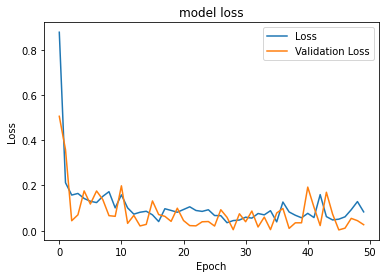

<Figure size 432x288 with 0 Axes>

In [23]:
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

1/1 [==============================] - 1s 741ms/step
Not a fruit


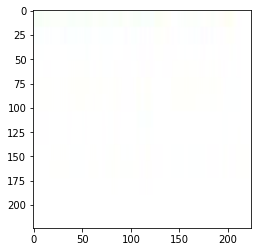

In [24]:
im = X_test[140]
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
img_class = max(out[0])
pred_label = list(out[0]).index(img_class)
if pred_label == 0:
    print("Not a fruit")
elif pred_label == 1:
    print('apple')
elif pred_label == 2:
    print("banana")
elif pred_label == 3:
    print('orange')
# if out[0][0] > out[0][1]:
#     print("Fruit")
# else:
#     print("Not Fruit")

In [25]:
# z=0
# for e,i in enumerate(os.listdir(img_path)):
  
#     if i.startswith("mixed_5"):
#         z += 1
#         img = cv2.imread(os.path.join(img_path,i))
#         ss.setBaseImage(img)
#         ss.switchToSelectiveSearchFast()
#         ssresults = ss.process()
#         imout = img.copy()
#         for e,result in enumerate(ssresults):
#             if e < 2000:
#                 x,y,w,h = result
#                 timage = imout[y:y+h,x:x+w]
#                 resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
#                 img = np.expand_dims(resized, axis=0)
#                 out= model_final.predict(img)
#                 if out[0][1] > 0.7 or  out[0][2] > 0.7 or  out[0][3] > 0.7:
#                     cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
#         plt.figure()
#         plt.imshow(cv2.cvtColor(imout, cv2.COLOR_BGR2RGB))

In [26]:
# You can visualize the results with a confusion matrix.
def plot_confusion_matrix(y_classified, y_true):
  # Compute confusion matrix
    c_mat = np.zeros((y_test.shape[1],y_test.shape[1]))
    for i in range(len(y_true)):
        c_mat[y_classified[i], y_true[i] ] += 1

    group_counts = ["{0:0.0f}".format(value) for value in c_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in c_mat.flatten()/np.sum(c_mat)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(c_mat.shape[0], c_mat.shape[1])

    plt.figure(figsize=(12,10))
    sn.heatmap(c_mat, annot=labels, fmt='', cmap='rocket_r')
    plt.title("Confusion Matrix")
    plt.ylabel('Output Class')
    plt.xlabel('Target Class')

39/39 [==============================] - 59s 2s/step - loss: 0.0650 - accuracy: 0.9763
Test loss: 0.06501960009336472
Test accuracy: 0.976287841796875
39/39 [==============================] - 59s 2s/step
Confusion matrix: 
 [[816   0   5   7]
 [  4 149   0   0]
 [ 13   0 116   0]
 [  0   0   0 113]]


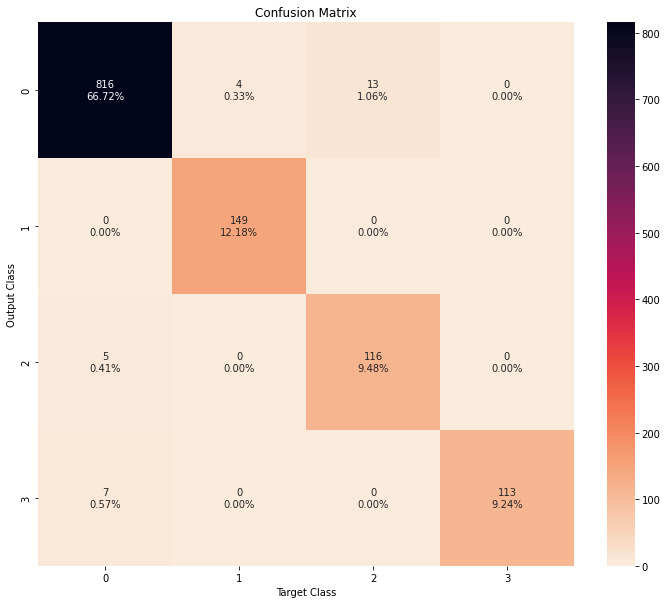

In [27]:
# Evaluate the trained model using keras built-in function
score = model_final.evaluate(X_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1]) 

y_classified = np.argmax(model_final.predict(X_test), axis=1)
y_true =  np.argmax(y_test, axis=1)
# Compute the confusion matrix
print("Confusion matrix: \n", confusion_matrix(y_true, y_classified))

# plot confusion matrix
plot_confusion_matrix(y_classified, y_true)

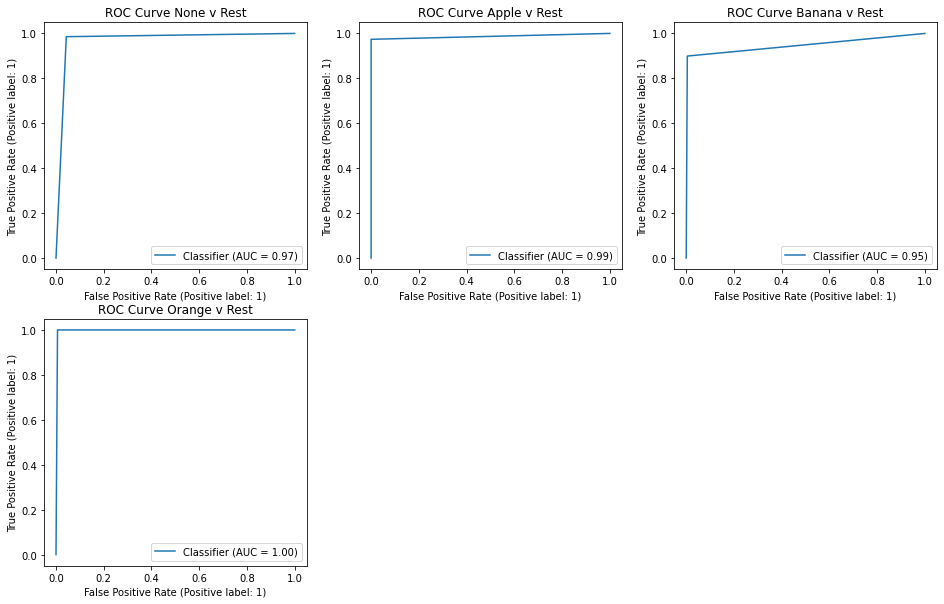

In [28]:
plt.figure(figsize = (16, 10))
classes = ['None','Apple', 'Banana', 'Orange']

for i in range(len(classes)):
    y_true_sub = np.array([int(y == i) for y in y_true])
    y_class_sub = np.array([int(y == i) for y in y_classified])
    
    roc_auc = metrics.roc_auc_score(y_true_sub,y_class_sub)

    ax = plt.subplot(2, 3, i+1)
    ax.set_title(classes[i])
    ax.legend([f"Class: {classes[i]}", "Rest"])
    ax.set_xlabel(f"P(x = {classes[i]})")

    # Calculates the ROC Coordinates and plots the ROC Curves
    fpr, tpr, threshold = metrics.roc_curve(y_true_sub, y_class_sub)
    #plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    RocCurveDisplay.from_predictions(y_true_sub, y_class_sub, ax = ax)
    ax.set_title(f"ROC Curve {classes[i]} v Rest")

In [29]:
metrics.matthews_corrcoef(y_true, y_classified, sample_weight=None)

0.9530707814617506